# Timeseries anomaly detection using an Autoencoder

**Author:** [pavithrasv](https://github.com/pavithrasv)<br>
**Date created:** 2020/05/31<br>
**Last modified:** 2020/05/31<br>
**Description:** Detect anomalies in a timeseries using an Autoencoder.

https://github.com/keras-team/keras-io/blob/master/examples/timeseries/ipynb/timeseries_anomaly_detection.ipynb

## Introduction

This script demonstrates how you can use a reconstruction convolutional
autoencoder model to detect anomalies in timeseries data.

## Setup

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform
from time import time as ti
from skimage.restoration import denoise_wavelet
import tensorflow as tf
import pickle

2024-07-08 14:07:52.048307: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 14:07:52.107289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artificial
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

We will use the `art_daily_small_noise.csv` file for training and the
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.

In [2]:
folder = '/scratch/Recordings2/DayMovePickle/'

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

In [3]:
#fig, ax = plt.subplots()
#df_daily_jumpsup.plot(legend=False, ax=ax)
#plt.show()

In [4]:
%%time

f = open(folder+'PickledPrep00007.p','rb')
x_train = pickle.load(f)

CPU times: user 13.1 s, sys: 11.3 s, total: 24.4 s
Wall time: 24.5 s


In [5]:
x_t1 = np.array(x_train)

In [6]:
x_shape = np.shape(x_t1)

## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [7]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_shape[1], x_shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")
model.summary()

2024-07-08 14:08:27.160752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:b3:00.0, compute capability: 8.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 32)          │       336,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 16)          │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 2, 16)          │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 4, 32)          │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 4, 1)           │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,281 (1.32 MB)

 Trainable params: 345,281 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [8]:
import csv
import tensorflow.keras.backend as K
from tensorflow import keras
import os

model_directory=folder+'saves/' # directory to save model history after every epoch 

class StoreModelHistory(keras.callbacks.Callback):

  def on_epoch_end(self,batch,logs=None):

    if not ('model_history.csv' in os.listdir(model_directory)):
      with open(model_directory+'model_history.csv','a') as f:
        y=csv.DictWriter(f,logs.keys())
        y.writeheader()

    with open(model_directory+'model_history.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)



In [9]:
from tensorflow.python.keras.backend import get_session
from tensorflow.python.keras.backend import clear_session
from tensorflow.python.keras.backend import set_session
import gc

In [10]:
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [11]:
MaxTensor = 250000
Loops = int(x_shape[0]/MaxTensor)+1
tic = ti()

In [26]:
for j in range(3):
    random.shuffle(x_t1)
    for i in range(Loops):
        if i == 0:
            x_t3=x_t1[:MaxTensor]
        elif i == Loops -1:
            x_t3=x_t1[MaxTensor*i:]
        else:
            x_t3=x_t1[MaxTensor*i:MaxTensor*(i+1)]
        
        x_t2 = tf.convert_to_tensor(x_t3)

        history = model.fit(
            x_t2,
            x_t2,
            epochs=10,
            batch_size=128,
            validation_split=0.1,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
                StoreModelHistory()
            ],
            verbose=0
        )
        #reset_keras()
        print(j, i, ti()-tic)
        model.save('TAD2_round'+str(j)+'.keras')
    if j ==0:
        model.optimizer.learning_rate.assign(0.005)
    elif j==1:
        model.optimizer.learning_rate.assign(0.001)

0 0 4844.903312206268
0 1 4937.960148334503
0 2 5013.132952213287
0 3 5088.676410913467
0 4 5173.177395105362
0 5 5266.87796664238
0 6 5359.391088247299
0 7 5443.121031999588
1 0 5544.487907171249
1 1 5649.086297750473
1 2 5743.097628831863
1 3 5827.397955656052
1 4 5902.140322446823
1 5 5968.047467470169
1 6 6026.009525537491
1 7 6107.509924888611
2 0 6206.899353265762
2 1 6300.297736644745
2 2 6393.153860330582
2 3 6459.864483594894
2 4 6553.005713224411
2 5 6628.509914159775
2 6 6712.901425600052
2 7 6778.806083440781


Let's plot training and validation loss to see how the training went.

In [27]:
history_dataframe = pd.read_csv(model_directory+'model_history.csv',sep=',')

In [28]:
EPOCH = len(history_dataframe) # number of epochs the model has trained for

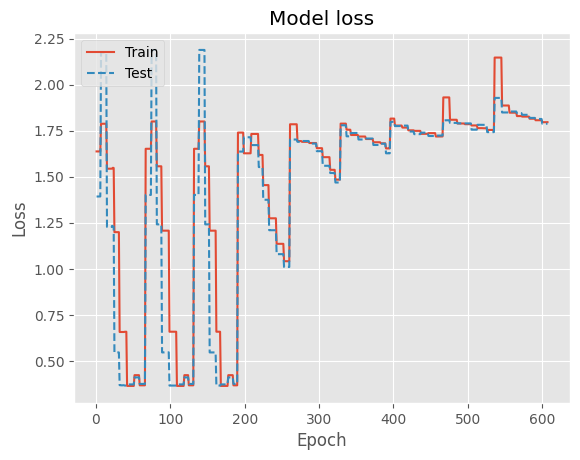

In [29]:
# Plot training & validation loss values
plt.style.use("ggplot")
plt.plot(range(1,EPOCH+1),
         history_dataframe['loss'])
plt.plot(range(1,EPOCH+1),
         history_dataframe['val_loss'],
         linestyle='--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data

In [ ]:

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()